In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

In [4]:
dataset_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
data_dir = tf.keras.utils.get_file('Images', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

793579520/793579520 [==============================] - 765s 1us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

20580


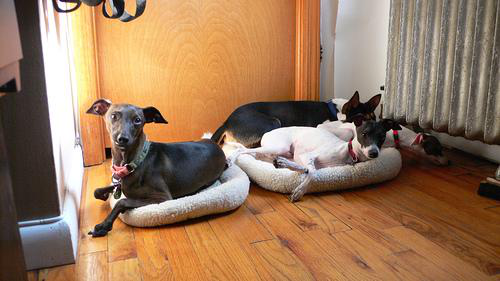

In [6]:
greyhound = list(data_dir.glob('n02091032-Italian_greyhound/*'))
PIL.Image.open(str(greyhound[0]))

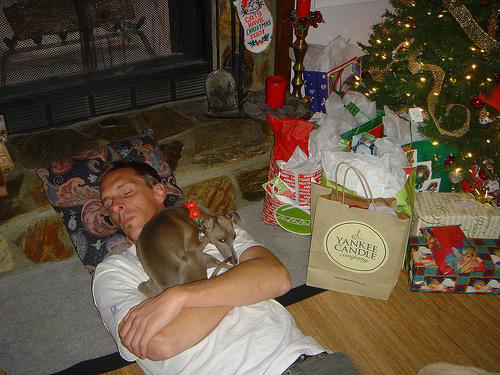

In [7]:
PIL.Image.open(str(greyhound[1]))

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

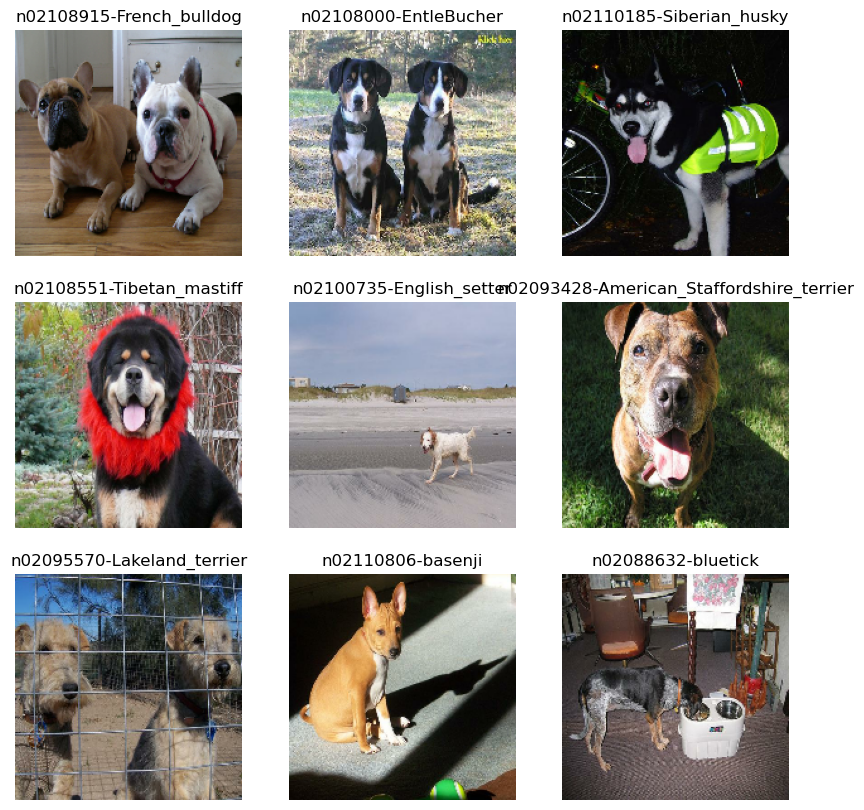

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.016243026 0.9973856


In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
515/515 [==============================] - 135s 251ms/step - loss: 4.6969 - accuracy: 0.0191 - val_loss: 4.5208 - val_accuracy: 0.0301
Epoch 2/10
515/515 [==============================] - 130s 251ms/step - loss: 4.3266 - accuracy: 0.0482 - val_loss: 4.3072 - val_accuracy: 0.0517
Epoch 3/10
515/515 [==============================] - 132s 253ms/step - loss: 3.9504 - accuracy: 0.1047 - val_loss: 4.2608 - val_accuracy: 0.0707
Epoch 4/10
515/515 [==============================] - 131s 251ms/step - loss: 3.2734 - accuracy: 0.2187 - val_loss: 4.5248 - val_accuracy: 0.0656
Epoch 5/10
515/515 [==============================] - 134s 257ms/step - loss: 2.2851 - accuracy: 0.4203 - val_loss: 5.3536 - val_accuracy: 0.0639
Epoch 6/10
515/515 [==============================] - 133s 255ms/step - loss: 1.3229 - accuracy: 0.6484 - val_loss: 7.2634 - val_accuracy: 0.0644
Epoch 7/10
515/515 [==============================] - 131s 253ms/step - loss: 0.6592 - accuracy: 0.8239 - val_loss: 9.7048 -

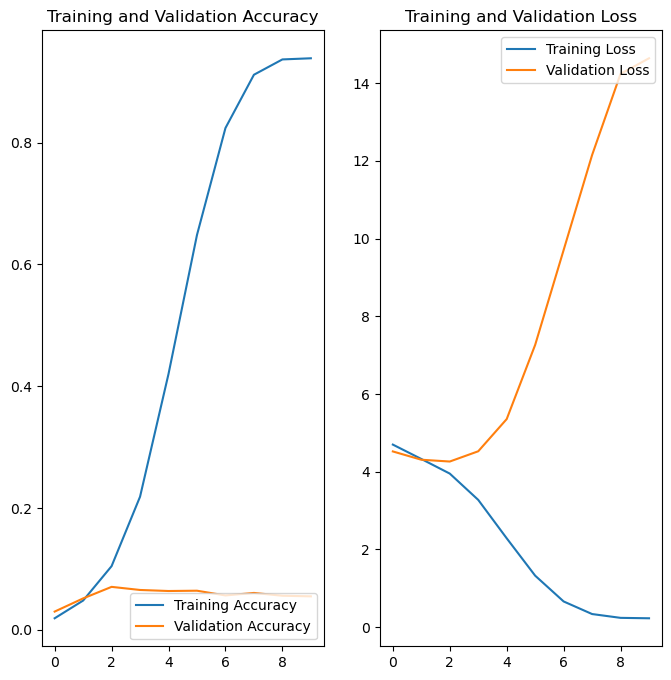

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

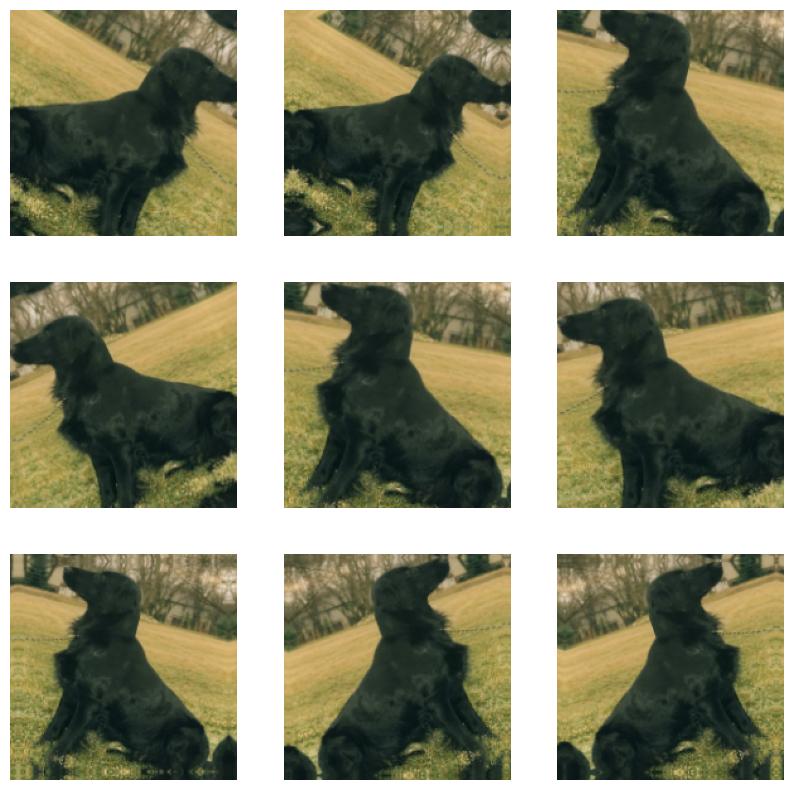

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [27]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
515/515 [==============================] - 156s 296ms/step - loss: 4.6896 - accuracy: 0.0190 - val_loss: 4.4697 - val_accuracy: 0.0272
Epoch 2/20
515/515 [==============================] - 152s 292ms/step - loss: 4.3386 - accuracy: 0.0434 - val_loss: 4.2467 - val_accuracy: 0.0573
Epoch 3/20
515/515 [==============================] - 153s 295ms/step - loss: 4.1557 - accuracy: 0.0663 - val_loss: 4.1327 - val_accuracy: 0.0746
Epoch 4/20
515/515 [==============================] - 156s 300ms/step - loss: 4.0133 - accuracy: 0.0903 - val_loss: 4.0535 - val_accuracy: 0.0838
Epoch 5/20
515/515 [==============================] - 153s 296ms/step - loss: 3.8913 - accuracy: 0.1099 - val_loss: 3.9754 - val_accuracy: 0.0984
Epoch 6/20
515/515 [==============================] - 154s 296ms/step - loss: 3.7831 - accuracy: 0.1255 - val_loss: 4.0508 - val_accuracy: 0.0877
Epoch 7/20
515/515 [==============================] - 149s 286ms/step - loss: 3.6877 - accuracy: 0.1376 - val_loss: 3.9788 -

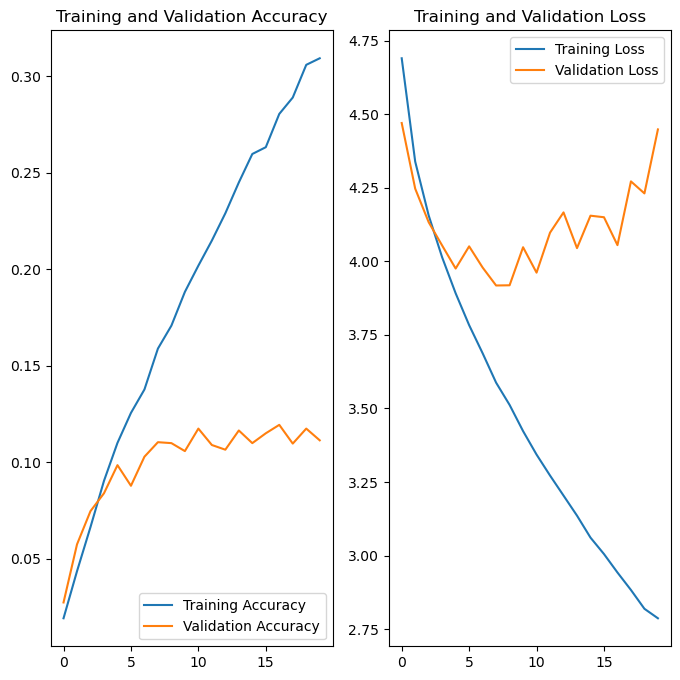

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
dog_url = "https://www.thesprucepets.com/thmb/hxWjs7evF2hP1Fb1c1HAvRi_Rw0=/2765x0/filters:no_upscale():strip_icc()/chinese-dog-breeds-4797219-hero-2a1e9c5ed2c54d00aef75b05c5db399c.jpg"
dog_path = tf.keras.utils.get_file('dog', origin=dog_url)

img = tf.keras.utils.load_img(
    dog_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 3s 3s/step
This image most likely belongs to n02087046-toy_terrier with a 21.68 percent confidence.
